## Feature Attribution: from naive to integrated gradients

- dataset: MNIST
- model: simple (custom) CNN

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.datasets import mnist

### Problem

When a NN makes prediction, we want to know:

 > *"Which input features (pixels) were most responsible for this output?"*

---

### Simple Gradients
First instinct might intuitively be to use **gradients**: just compute the gradient of the output $F(x)$ w.r.t. each input feature $x_i$ (pixel):
$$\text{SimpleGrad}_i(x) = \frac{\partial{F(x)}}{\partial{x_i}}$$

But this yields poor (often noisy) explanations because of:
- **Saturation Problem** (near zero gradient despite being crucial for the prediction)
- **Local Explanation Only** (information only about small changes at the specific input point)
- **Gradient Sharpness**: (leads to noisy attributions)

In [4]:
def simple_gradients(model, images, target_class_idx):
    """Calculate simple gradients of the output w.r.t. the input"""
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(images)
        predictions = model(images)
        outputs = predictions[:, target_class_idx]
        
    return tape.gradient(outputs, images)

### Integrated Gradients (Sundararajan et al., 2017)

The key insight: **To understand feature's importance, we should measure how the model's prediction changes as we gradually introduce that feature.**

$$\text{IG}_i(x) = (x_i - x'_i) \times \int_{\alpha=0}^{1} \frac{\partial F(x' + \alpha \times (x - x'))}{\partial x_i} d\alpha$$

Where:
- $x$ is the input
- $x'$ is the baseline (typically zeros representing "absence of feature")
- $\alpha$ is a parameter that interpolates between baseline and input

Do not look at the gradient at just the input point, but:
1. Start w/ a *baseline* (feature absence)
2. Slowly transform into the actual input
3. Track how the prediction changes along this *path*


**Path**: baseline $\to$ input
- $Path(α) = baseline + α × (input - baseline)$


**Why integration?**
- to measure the *cumulative effect* of each feature across the entire path
- at each step along the path, measure how much the output changes when the feature value is slightly increased. Then add up (integrate) all the incremental contributions to get the *total importance*.


Integrated Gradients has the following properties:

1. **Sensitivity**: If the model output differs between the input and baseline, and they differ in exactly one feature, that feature receives a non-zero attribution.

2. **Implementation Invariance**: Attributions are identical for functionally equivalent networks.

3. **Completeness**: The attributions sum to the difference between the model output at the input and baseline:
   $$\sum_{i} \text{IG}_i(x) = F(x) - F(x')$$

4. **Overcome Saturation**: By integrating along a path, IG captures the contributions of features even when gradients are saturated at the input point.


In [5]:
class IntegratedGradients:
    def __init__(self, model, baseline=None):
        self.model = model
        self.baseline = baseline
    
    def _get_gradients(self, inputs, target_class_idx):
        """Compute gradients of outputs with respect to inputs"""
        inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)
        
        with tf.GradientTape() as tape:
            tape.watch(inputs)
            predictions = self.model(inputs)
            outputs = predictions[:, target_class_idx]
            
        return tape.gradient(outputs, inputs)
    
    def integrated_gradients(self, input_image, target_class_idx, baseline=None, num_steps=50):
        """Calculate integrated gradients"""

        # Determine baseline, default is all zeros
        if baseline is None:
            baseline = self.baseline if self.baseline is not None else tf.zeros_like(input_image)
    
        input_image = tf.convert_to_tensor(input_image, tf.float32)
        baseline    = tf.convert_to_tensor(baseline, tf.float32)
        
        # Generate alphas for interpolation
        alphas = tf.linspace(0.0, 1.0, num_steps+1)
        # Path(alpha) = baseline * alpha (input - baseline)
        
        # Collect gradients
        gradient_list = []
        
        for alpha in alphas:
            # Calculate interpolated inputs
            interpolated_input = baseline + alpha * (input_image - baseline)
            
            # Get gradients
            gradient = self._get_gradients(interpolated_input, target_class_idx)
            gradient_list.append(gradient)
        
        # Stack and average gradients
        all_gradients = tf.stack(gradient_list, axis=0)
        avg_gradients = tf.reduce_mean(all_gradients, axis=0)
        
        # Scale attributions
        integrated_grad = (input_image - baseline) * avg_gradients

        return integrated_grad

In [6]:
# Load and preprocess MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

In [7]:
def create_model():
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

### Visualizing Attribution Maps

In attribution maps:
- **Red (positive) values**: Features that increase the predicted probability of the target class
- **Blue (negative) values**: Features that decrease the predicted probability
- **Intensity**: Magnitude of attribution (importance)

In [8]:
def compare_attribution_methods(model, image, true_label):
    """Compare simple gradients to integrated gradients"""
    # Get model prediction
    pred = model.predict(image)
    pred_class = np.argmax(pred[0])
    confidence = pred[0][pred_class]
    
    print(f"True label: {true_label}")
    print(f"Predicted class: {pred_class} with confidence: {confidence:.4f}")
    
    # Calculate simple gradients
    simple_grads = simple_gradients(model, image, pred_class)
    simple_grads_np = simple_grads.numpy()
    
    # Calculate integrated gradients
    ig = IntegratedGradients(model)
    int_grads = ig.integrated_gradients(image, pred_class, baseline=np.zeros_like(image), num_steps=50)
    int_grads_np = int_grads.numpy()
    
    simple_grads_2d = np.squeeze(simple_grads_np)
    if simple_grads_2d.ndim == 3:  # If there's a channel dimension
        simple_grads_2d = np.sum(simple_grads_2d, axis=2)
        
    int_grads_2d = np.squeeze(int_grads_np)
    if int_grads_2d.ndim == 3:  # If there's a channel dimension
        int_grads_2d = np.sum(int_grads_2d, axis=2)
    
    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(8, 6))
    
    # Plot original image
    axes[0].imshow(np.squeeze(image), cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Plot simple gradients
    vmax = np.max(np.abs(simple_grads_2d)) + 1e-9
    im = axes[1].imshow(simple_grads_2d, cmap='seismic', vmin=-vmax, vmax=vmax)
    axes[1].set_title('Simple Gradients')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
    
    # Plot integrated gradients
    vmax = np.max(np.abs(int_grads_2d)) + 1e-9
    im = axes[2].imshow(int_grads_2d, cmap='seismic', vmin=-vmax, vmax=vmax)
    axes[2].set_title('Integrated Gradients')
    axes[2].axis('off')
    plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()
    
    # Plot histogram of attribution values
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
    axes[0].hist(simple_grads_2d.flatten(), bins=50, alpha=0.7)
    axes[0].set_title('Simple Gradients Distribution')
    axes[0].set_xlabel('Attribution Value')
    axes[0].set_ylabel('Count')
    
    axes[1].hist(int_grads_2d.flatten(), bins=50, alpha=0.7)
    axes[1].set_title('Integrated Gradients Distribution')
    axes[1].set_xlabel('Attribution Value')
    axes[1].set_ylabel('Count')

    
    plt.tight_layout()
    plt.show()
    
    return simple_grads_np, int_grads_np

In [9]:
model = create_model()
_ = model.fit(x_train, y_train, batch_size=128, epochs=8, validation_split=0.1, verbose=1)

Epoch 1/8


c:\Users\simon\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8459 - loss: 0.5305 - val_accuracy: 0.9800 - val_loss: 0.0709
Epoch 2/8
422/422 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9784 - loss: 0.0713 - val_accuracy: 0.9867 - val_loss: 0.0514
Epoch 3/8
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9868 - loss: 0.0424 - val_accuracy: 0.9878 - val_loss: 0.0421
Epoch 4/8
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9907 - loss: 0.0312 - val_accuracy: 0.9907 - val_loss: 0.0339
Epoch 5/8
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9924 - loss: 0.0245 - val_accuracy: 0.9888 - val_loss: 0.0377
Epoch 6/8
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9939 - loss: 0.0193 - val_accuracy: 0.9897 - val_loss: 0.0392
Epoch 7/8
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9954 - loss: 0.0145 - val_accuracy: 0.9908 - val_loss: 0.0366
Epoch 8/8
422/422 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.9963 - loss: 0.0109 - val_accuracy: 0.9903 - v


--- Example 15 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
True label: 5
Predicted class: 5 with confidence: 1.0000


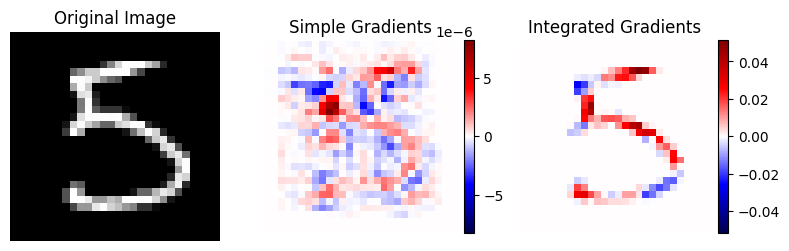

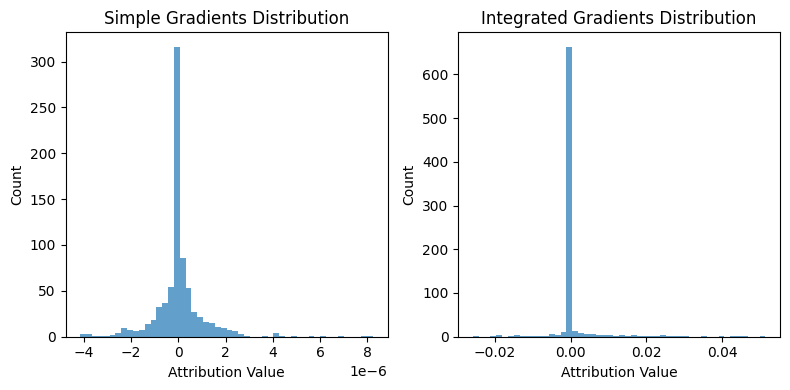


--- Example 42 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
True label: 4
Predicted class: 4 with confidence: 1.0000


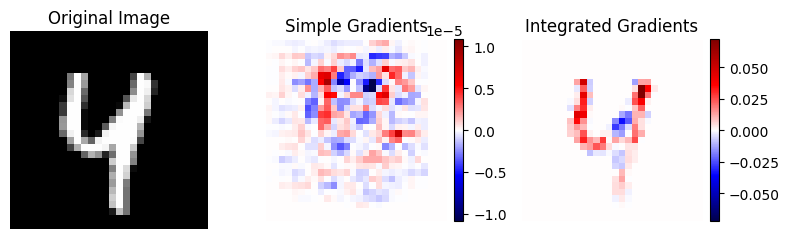

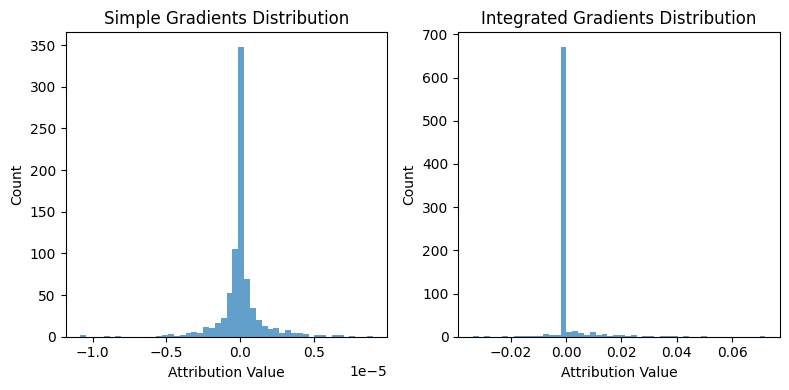


--- Example 67 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
True label: 4
Predicted class: 4 with confidence: 1.0000


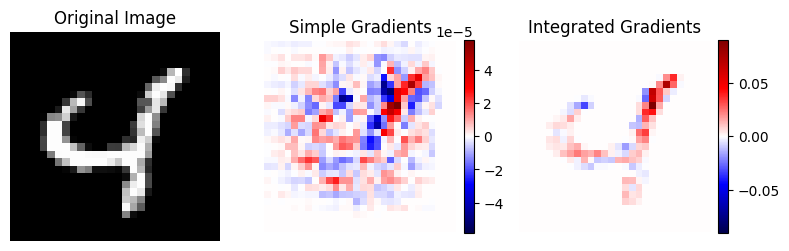

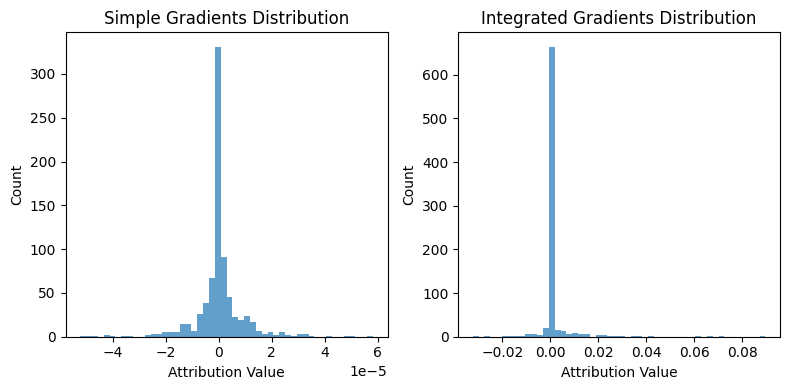

In [10]:
# Analyze a few examples
for idx in [15, 42, 67]:
    image = x_test[idx:idx+1]
    true_label = y_test[idx]
    print(f"\n--- Example {idx} ---")
    simple_grads, int_grads = compare_attribution_methods(model, image, true_label)